In [ ]:
# Energy Forecasting with GRU - Jupyter Notebook Version
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

#uploaded = files.upload()
#df=pd.read_csv(list(uploaded.keys())[0],sep=',') #carga el dataset (en CSV) desde el pc en un dataframe de pandas


Saving DemaReal.csv to DemaReal.csv


In [ ]:
host = 'jupyter.dreadcode.dev'
port = 5432
database = 'postgres'
user = 'postgres'
password = '5~;X*hLkvdf>xa*T'

In [ ]:
# Configuración de la conexión
conn = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password
)

# Crear un cursor
cur = conn.cursor()

# Ejecutar consulta para obtener datos de la vista
conn.rollback()  # Esto limpia el estado de transacción fallida. Sino una vez falle una consulta se va a quedar pegado.

cur.execute('SELECT "Date", "Consumo" FROM tablasxm_dev.demareal;')

datos_generacion = cur.fetchall()

column_names = [desc[0] for desc in cur.description]
df_generacion = pd.DataFrame(datos_generacion, columns=column_names)


In [ ]:
df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y %H:%M')
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Hour'] = df['Date'].dt.hour

Epoch 1/10, Loss: 0.0020
Epoch 2/10, Loss: 0.0009
Epoch 3/10, Loss: 0.0008
Epoch 4/10, Loss: 0.0007
Epoch 5/10, Loss: 0.0007
Epoch 6/10, Loss: 0.0007
Epoch 7/10, Loss: 0.0006
Epoch 8/10, Loss: 0.0006
Epoch 9/10, Loss: 0.0006
Epoch 10/10, Loss: 0.0006


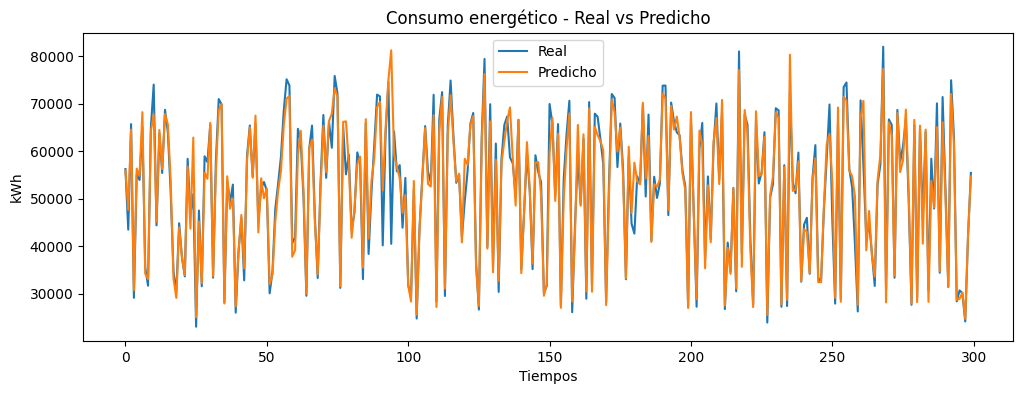

MAE: 2196.4404
MSE: 12555853.0000
R2 Score: 0.9408


In [ ]:
features = ['Hour','DayOfWeek','Day','Month','Year']

X = df[features]
Y = df[['Consumo']]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(Y)

sequence_length = 24

class EnergyDataset(Dataset):
    def __init__(self, x, y, seq_len):
        self.x = []
        self.y = []
        for i in range(len(x) - seq_len):
            self.x.append(x[i:i+seq_len])
            self.y.append(y[i+seq_len])
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Crear datasets
dataset = EnergyDataset(X_scaled, y_scaled, sequence_length)
train_size = int(0.7 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 🧠 4. Modelo GRU
class EnergyGRUModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(EnergyGRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model = EnergyGRUModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 🔁 5. Entrenamiento
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        output = model(x_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# 📊 6. Evaluación
model.eval()
preds, actuals = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        output = model(x_batch)
        preds.append(output.numpy())
        actuals.append(y_batch.numpy())

preds = scaler_y.inverse_transform(np.vstack(preds))
actuals = scaler_y.inverse_transform(np.vstack(actuals))

# 📈 7. Visualización
plt.figure(figsize=(12, 4))
plt.plot(actuals[:300], label="Real")
plt.plot(preds[:300], label="Predicho")
plt.title("Consumo energético - Real vs Predicho")
plt.xlabel("Tiempos")
plt.ylabel("kWh")
plt.legend()
plt.show()

# Calcular métricas
mae = mean_absolute_error(actuals, preds)
mse = mean_squared_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

<ipython-input-3-2366925174>:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.x = torch.tensor(self.x, dtype=torch.float32)


Epoch 1/10, Loss: 0.0016
Epoch 2/10, Loss: 0.0008
Epoch 3/10, Loss: 0.0007
Epoch 4/10, Loss: 0.0007
Epoch 5/10, Loss: 0.0007
Epoch 6/10, Loss: 0.0006
Epoch 7/10, Loss: 0.0006
Epoch 8/10, Loss: 0.0006
Epoch 9/10, Loss: 0.0006
Epoch 10/10, Loss: 0.0006


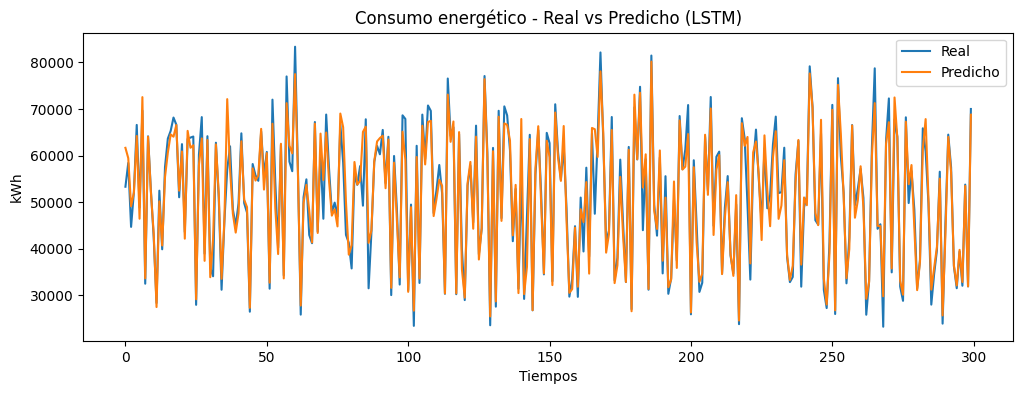

MAE: 2252.4133
MSE: 13055128.0000
R2 Score: 0.9381


In [ ]:
# prompt: Quiero generar el modelo LSTM

features = ['Hour','DayOfWeek','Day','Month','Year']

X = df[features]
Y = df[['Consumo']]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(Y)

sequence_length = 24

class EnergyDataset(Dataset):
    def __init__(self, x, y, seq_len):
        self.x = []
        self.y = []
        for i in range(len(x) - seq_len):
            self.x.append(x[i:i+seq_len])
            self.y.append(y[i+seq_len])
        self.x = torch.tensor(self.x, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Crear datasets
dataset = EnergyDataset(X_scaled, y_scaled, sequence_length)
train_size = int(0.7 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 🧠 4. Modelo LSTM
class EnergyLSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(EnergyLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 64).to(x.device)
        c0 = torch.zeros(2, x.size(0), 64).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = EnergyLSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 🔁 5. Entrenamiento
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        output = model(x_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# 📊 6. Evaluación
model.eval()
preds, actuals = [], []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        output = model(x_batch)
        preds.append(output.numpy())
        actuals.append(y_batch.numpy())

preds = scaler_y.inverse_transform(np.vstack(preds))
actuals = scaler_y.inverse_transform(np.vstack(actuals))

# 📈 7. Visualización
plt.figure(figsize=(12, 4))
plt.plot(actuals[:300], label="Real")
plt.plot(preds[:300], label="Predicho")
plt.title("Consumo energético - Real vs Predicho (LSTM)")
plt.xlabel("Tiempos")
plt.ylabel("kWh")
plt.legend()
plt.show()

# Calcular métricas
mae = mean_absolute_error(actuals, preds)
mse = mean_squared_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")
